In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.model_selection import  train_test_split, cross_validate, RepeatedKFold, ShuffleSplit, RandomizedSearchCV, GridSearchCV, cross_val_score, learning_curve
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import Lasso

In [23]:
# read the file
path = '/content/drive/MyDrive/Applied Analytics ML Pipeline/Datasets/df_log_scaled.csv'
data_ori = pd.read_csv(path)

In [24]:
data_ori

,ABETA_bl,TAU_bl,PTAU_bl,AGE,PTEDUCAT,APOE4,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,RAVLT_perc_forgetting_bl,MMSE_bl,TRABSCOR_bl,mPACCdigit_bl,mPACCtrailsB_bl,FAQ_bl,CDRSB_bl,ADAS11_bl,ADAS13_bl,ADASQ4_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,FDG_bl,PTGENDER_Female,PTETHCAT_Not Hisp/Latino,PTETHCAT_Unknown,PTRACCAT_White,PTRACCAT_Am Indian/Alaskan,PTRACCAT_Asian,PTRACCAT_Black,PTRACCAT_Hawaiian/Other PI,PTRACCAT_More than one,PTRACCAT_Unknown,PTMARRY_Never married,PTMARRY_Married,PTMARRY_Widowed,PTMARRY_Divorced,PTMARRY_Unknown,index,tran_1to2_m6,tran_1to2_m6to12,tran_1to2_m12to24
0,0.318075,0.305251,0.305932,0.697802,0.461538,0.0,0.333333,0.214286,0.466667,0.858974,0.285714,0.735315,0.342900,0.259999,0.000000,0.000000,0.803182,0.739688,0.7,0.601630,0.260891,0.240328,0.177313,0.479244,0.352713,0.365925,0.161394,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0.081468,0.588798,0.620408,0.686813,0.923077,0.0,0.438596,0.571429,0.800000,0.923077,0.857143,0.648989,0.443970,0.387221,0.620607,0.196191,0.409091,0.625000,1.0,0.422600,0.609551,0.406153,0.696749,0.487383,0.397442,0.476616,0.371141,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
2,0.309673,0.578833,0.604621,0.777473,1.000000,0.0,0.175439,0.428571,0.533333,1.000000,0.857143,0.499259,0.545869,0.433817,0.620607,0.472707,0.757727,0.739688,0.6,0.550419,0.591804,0.400858,0.684019,0.404170,0.475692,0.635794,0.243911,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0
3,0.135982,0.384560,0.323268,0.436813,0.538462,1.0,0.192982,0.071429,0.400000,1.000000,0.285714,0.668232,0.352117,0.172637,0.513296,0.348368,0.787727,0.822812,1.0,0.590188,0.384156,0.295159,0.374176,0.186150,0.342065,0.395670,0.371141,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,3,0,0,1
4,0.702897,0.442396,0.326979,0.489011,0.846154,0.0,0.315789,0.571429,0.666667,0.905983,1.000000,0.503777,0.674251,0.594502,0.350379,0.000000,0.272727,0.312500,0.5,0.665077,0.057438,0.277496,0.292566,0.384760,0.251704,0.402523,0.688426,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,4,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,0.284533,0.315240,0.293157,0.692308,0.538462,0.0,0.245614,0.214286,0.466667,1.000000,0.285714,0.356623,0.305588,0.413301,0.734361,0.472707,0.363636,0.437500,0.7,0.788650,0.211197,0.211828,0.147761,0.376871,0.422004,0.114031,0.292529,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,646,0,0,1
630,0.530147,0.641091,0.618615,0.379121,0.692308,1.0,0.315789,0.428571,0.600000,0.894231,1.000000,0.311055,0.517389,0.588130,0.000000,0.196191,0.409091,0.468750,0.7,0.420615,0.675863,0.450514,0.635826,0.496462,0.591629,0.418152,1.000000,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,647,0,0,0
631,0.275728,0.784616,0.799980,0.678571,0.769231,0.5,0.649123,0.928571,0.266667,0.274725,0.571429,0.701541,0.533456,0.491550,0.000000,0.472707,0.454545,0.500000,0.6,0.664926,0.747338,0.468532,0.478518,0.572600,0.575742,0.466574,0.313352,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,648,0,0,0
632,1.000000,0.496146,0.476062,0.181319,0.692308,0.5,0.508772,0.500000,0.400000,0.492308,0.714286,0.490088,0.656633,0.644795,0.513296,0.472707,0.363636,0.437500,0.5,0.224906,0.531462,0.265541,0.416231,0.467097,0.436989,0.094445,0.497951,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,649,0,0,0


In [25]:
features_df = data_ori.drop(columns=['index'])

In [26]:
# use only last transition as label for mean comparison
early_labels = ['tran_1to2_m6', 'tran_1to2_m6to12']
last_label_df = features_df.drop(early_labels, axis = 1)

In [27]:
 last_label_df

,ABETA_bl,TAU_bl,PTAU_bl,AGE,PTEDUCAT,APOE4,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,RAVLT_perc_forgetting_bl,MMSE_bl,TRABSCOR_bl,mPACCdigit_bl,mPACCtrailsB_bl,FAQ_bl,CDRSB_bl,ADAS11_bl,ADAS13_bl,ADASQ4_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,FDG_bl,PTGENDER_Female,PTETHCAT_Not Hisp/Latino,PTETHCAT_Unknown,PTRACCAT_White,PTRACCAT_Am Indian/Alaskan,PTRACCAT_Asian,PTRACCAT_Black,PTRACCAT_Hawaiian/Other PI,PTRACCAT_More than one,PTRACCAT_Unknown,PTMARRY_Never married,PTMARRY_Married,PTMARRY_Widowed,PTMARRY_Divorced,PTMARRY_Unknown,tran_1to2_m12to24
0,0.318075,0.305251,0.305932,0.697802,0.461538,0.0,0.333333,0.214286,0.466667,0.858974,0.285714,0.735315,0.342900,0.259999,0.000000,0.000000,0.803182,0.739688,0.7,0.601630,0.260891,0.240328,0.177313,0.479244,0.352713,0.365925,0.161394,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,0.081468,0.588798,0.620408,0.686813,0.923077,0.0,0.438596,0.571429,0.800000,0.923077,0.857143,0.648989,0.443970,0.387221,0.620607,0.196191,0.409091,0.625000,1.0,0.422600,0.609551,0.406153,0.696749,0.487383,0.397442,0.476616,0.371141,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,0.309673,0.578833,0.604621,0.777473,1.000000,0.0,0.175439,0.428571,0.533333,1.000000,0.857143,0.499259,0.545869,0.433817,0.620607,0.472707,0.757727,0.739688,0.6,0.550419,0.591804,0.400858,0.684019,0.404170,0.475692,0.635794,0.243911,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3,0.135982,0.384560,0.323268,0.436813,0.538462,1.0,0.192982,0.071429,0.400000,1.000000,0.285714,0.668232,0.352117,0.172637,0.513296,0.348368,0.787727,0.822812,1.0,0.590188,0.384156,0.295159,0.374176,0.186150,0.342065,0.395670,0.371141,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1
4,0.702897,0.442396,0.326979,0.489011,0.846154,0.0,0.315789,0.571429,0.666667,0.905983,1.000000,0.503777,0.674251,0.594502,0.350379,0.000000,0.272727,0.312500,0.5,0.665077,0.057438,0.277496,0.292566,0.384760,0.251704,0.402523,0.688426,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,0.284533,0.315240,0.293157,0.692308,0.538462,0.0,0.245614,0.214286,0.466667,1.000000,0.285714,0.356623,0.305588,0.413301,0.734361,0.472707,0.363636,0.437500,0.7,0.788650,0.211197,0.211828,0.147761,0.376871,0.422004,0.114031,0.292529,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
630,0.530147,0.641091,0.618615,0.379121,0.692308,1.0,0.315789,0.428571,0.600000,0.894231,1.000000,0.311055,0.517389,0.588130,0.000000,0.196191,0.409091,0.468750,0.7,0.420615,0.675863,0.450514,0.635826,0.496462,0.591629,0.418152,1.000000,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
631,0.275728,0.784616,0.799980,0.678571,0.769231,0.5,0.649123,0.928571,0.266667,0.274725,0.571429,0.701541,0.533456,0.491550,0.000000,0.472707,0.454545,0.500000,0.6,0.664926,0.747338,0.468532,0.478518,0.572600,0.575742,0.466574,0.313352,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0
632,1.000000,0.496146,0.476062,0.181319,0.692308,0.5,0.508772,0.500000,0.400000,0.492308,0.714286,0.490088,0.656633,0.644795,0.513296,0.472707,0.363636,0.437500,0.5,0.224906,0.531462,0.265541,0.416231,0.467097,0.436989,0.094445,0.497951,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0


## Mean Comparison

In [29]:
# mean comparison between groups
summary = last_label_df.groupby('tran_1to2_m12to24').mean()
summary

,ABETA_bl,TAU_bl,PTAU_bl,AGE,PTEDUCAT,APOE4,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,RAVLT_perc_forgetting_bl,MMSE_bl,TRABSCOR_bl,mPACCdigit_bl,mPACCtrailsB_bl,FAQ_bl,CDRSB_bl,ADAS11_bl,ADAS13_bl,ADASQ4_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,FDG_bl,PTGENDER_Female,PTETHCAT_Not Hisp/Latino,PTETHCAT_Unknown,PTRACCAT_White,PTRACCAT_Am Indian/Alaskan,PTRACCAT_Asian,PTRACCAT_Black,PTRACCAT_Hawaiian/Other PI,PTRACCAT_More than one,PTRACCAT_Unknown,PTMARRY_Never married,PTMARRY_Married,PTMARRY_Widowed,PTMARRY_Divorced,PTMARRY_Unknown
tran_1to2_m12to24,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.507575,0.428456,0.42033,0.479757,0.698541,0.288214,0.436690,0.452118,0.441621,0.644161,0.694817,0.469927,0.592316,0.577826,0.281541,0.283587,0.385233,0.415649,0.517680,0.541383,0.517750,0.406904,0.472735,0.466823,0.472359,0.421424,0.469543,0.418048,0.974217,0.001842,0.933702,0.001842,0.016575,0.029466,0.001842,0.012891,0.003683,0.020258,0.775322,0.104972,0.093923,0.005525
1,0.350604,0.512753,0.51247,0.529374,0.697380,0.461538,0.288606,0.346154,0.464469,0.809956,0.544741,0.591914,0.419114,0.396138,0.478971,0.405130,0.528961,0.573709,0.702198,0.606843,0.407116,0.364037,0.396062,0.391720,0.394935,0.447317,0.413209,0.351648,0.967033,0.000000,0.967033,0.000000,0.021978,0.010989,0.000000,0.000000,0.000000,0.010989,0.824176,0.098901,0.065934,0.000000


In [31]:
# separate into groups based on label
trans_0 = last_label_df[last_label_df['tran_1to2_m12to24']==0]
trans_1 = last_label_df[last_label_df['tran_1to2_m12to24']==1]

In [32]:
# get significance on group difference
trans_diff_dict = dict()
attributes  = last_label_df.columns.tolist()

attributes = [e for e in attributes]
for column in attributes:
  A=trans_0[column].tolist()
  B=trans_1[column].tolist()
  t=ttest_ind(A,B).pvalue
  trans_diff_dict[column] = t

In [33]:
trans_diff_dict

{'ABETA_bl': 4.1332899666544716e-07,
 'ADAS11_bl': 3.379066543788202e-11,
 'ADAS13_bl': 3.2936533166086454e-12,
 'ADASQ4_bl': 6.885778198528736e-11,
 'AGE': 0.032979324504544986,
 'APOE4': 7.206647044534701e-06,
 'CDRSB_bl': 1.400708645211548e-06,
 'Entorhinal_bl': 9.269533016111165e-05,
 'FAQ_bl': 8.795500348483632e-10,
 'FDG_bl': 0.004767051468036993,
 'Fusiform_bl': 7.35822007742909e-05,
 'Hippocampus_bl': 1.5653943547928085e-07,
 'ICV_bl': 0.18358819253558467,
 'MMSE_bl': 1.2543711142261946e-07,
 'MidTemp_bl': 2.01406242506951e-05,
 'PTAU_bl': 1.0374908201352503e-05,
 'PTEDUCAT': 0.9606906941765361,
 'PTETHCAT_Not Hisp/Latino': 0.6951463799100404,
 'PTETHCAT_Unknown': 0.6826010856912772,
 'PTGENDER_Female': 0.23371938294133204,
 'PTMARRY_Divorced': 0.3884869979264305,
 'PTMARRY_Married': 0.296696992475133,
 'PTMARRY_Never married': 0.5489146126729008,
 'PTMARRY_Unknown': 0.47802679448354457,
 'PTMARRY_Widowed': 0.8609502398011374,
 'PTRACCAT_Am Indian/Alaskan': 0.6826010856912772,


In [34]:
# show only those that are significant

sig_diff = dict()
for key in trans_diff_dict.keys():
  if trans_diff_dict[key] <= 0.05:
    sig_diff[key] = trans_diff_dict[key]

sorted_sig_diff = sorted(sig_diff.items(), key=lambda x: x[1])
sorted_sig_diff_df = pd.DataFrame(sorted_sig_diff)
sorted_sig_diff_df.columns = ['attribute', 'p_value']
sorted_sig_diff_df

,attribute,p_value
0,tran_1to2_m12to24,0.000000e+00
1,mPACCtrailsB_bl,3.605480e-16
2,mPACCdigit_bl,1.597498e-14
3,RAVLT_immediate_bl,8.292616e-13
4,ADAS13_bl,3.293653e-12
5,ADAS11_bl,3.379067e-11
6,ADASQ4_bl,6.885778e-11
7,FAQ_bl,8.795500e-10
8,RAVLT_perc_forgetting_bl,4.742793e-08
9,MMSE_bl,1.254371e-07


In [36]:
# include the means of these attributes.
sig_attributes = list(sig_diff.keys())
sig_attributes.remove('tran_1to2_m12to24')
sig_sum = summary[sig_attributes].T
sig_sum.columns = ['no_transition_mean', 'transition_mean']
sig_sum

,no_transition_mean,transition_mean
ABETA_bl,0.507575,0.350604
TAU_bl,0.428456,0.512753
PTAU_bl,0.420330,0.512470
AGE,0.479757,0.529374
APOE4,0.288214,0.461538
RAVLT_immediate_bl,0.436690,0.288606
RAVLT_learning_bl,0.452118,0.346154
RAVLT_perc_forgetting_bl,0.644161,0.809956
MMSE_bl,0.694817,0.544741
TRABSCOR_bl,0.469927,0.591914


In [37]:
# merge significance and means 
diff_sig_merged = pd.merge(left=sorted_sig_diff_df, right=sig_sum, left_on='attribute', right_index=True)
diff_sig_merged

,attribute,p_value,no_transition_mean,transition_mean
1,mPACCtrailsB_bl,3.605480e-16,0.577826,0.396138
2,mPACCdigit_bl,1.597498e-14,0.592316,0.419114
3,RAVLT_immediate_bl,8.292616e-13,0.436690,0.288606
4,ADAS13_bl,3.293653e-12,0.415649,0.573709
5,ADAS11_bl,3.379067e-11,0.385233,0.528961
6,ADASQ4_bl,6.885778e-11,0.517680,0.702198
7,FAQ_bl,8.795500e-10,0.281541,0.478971
8,RAVLT_perc_forgetting_bl,4.742793e-08,0.644161,0.809956
9,MMSE_bl,1.254371e-07,0.694817,0.544741
10,Hippocampus_bl,1.565394e-07,0.517750,0.407116


In [38]:
%cd '/content/drive/MyDrive/Applied Analytics ML Pipeline/outputs'
diff_sig_merged.to_csv('diff_sig_merged.csv', index=False)

/content/drive/MyDrive/Applied Analytics ML Pipeline/outputs


## Feature Importance

In [39]:
y = last_label_df[['tran_1to2_m12to24']]
X = last_label_df.drop(['tran_1to2_m12to24'], axis = 1)
X

,ABETA_bl,TAU_bl,PTAU_bl,AGE,PTEDUCAT,APOE4,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,RAVLT_perc_forgetting_bl,MMSE_bl,TRABSCOR_bl,mPACCdigit_bl,mPACCtrailsB_bl,FAQ_bl,CDRSB_bl,ADAS11_bl,ADAS13_bl,ADASQ4_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,FDG_bl,PTGENDER_Female,PTETHCAT_Not Hisp/Latino,PTETHCAT_Unknown,PTRACCAT_White,PTRACCAT_Am Indian/Alaskan,PTRACCAT_Asian,PTRACCAT_Black,PTRACCAT_Hawaiian/Other PI,PTRACCAT_More than one,PTRACCAT_Unknown,PTMARRY_Never married,PTMARRY_Married,PTMARRY_Widowed,PTMARRY_Divorced,PTMARRY_Unknown
0,0.318075,0.305251,0.305932,0.697802,0.461538,0.0,0.333333,0.214286,0.466667,0.858974,0.285714,0.735315,0.342900,0.259999,0.000000,0.000000,0.803182,0.739688,0.7,0.601630,0.260891,0.240328,0.177313,0.479244,0.352713,0.365925,0.161394,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0
1,0.081468,0.588798,0.620408,0.686813,0.923077,0.0,0.438596,0.571429,0.800000,0.923077,0.857143,0.648989,0.443970,0.387221,0.620607,0.196191,0.409091,0.625000,1.0,0.422600,0.609551,0.406153,0.696749,0.487383,0.397442,0.476616,0.371141,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0
2,0.309673,0.578833,0.604621,0.777473,1.000000,0.0,0.175439,0.428571,0.533333,1.000000,0.857143,0.499259,0.545869,0.433817,0.620607,0.472707,0.757727,0.739688,0.6,0.550419,0.591804,0.400858,0.684019,0.404170,0.475692,0.635794,0.243911,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0
3,0.135982,0.384560,0.323268,0.436813,0.538462,1.0,0.192982,0.071429,0.400000,1.000000,0.285714,0.668232,0.352117,0.172637,0.513296,0.348368,0.787727,0.822812,1.0,0.590188,0.384156,0.295159,0.374176,0.186150,0.342065,0.395670,0.371141,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0
4,0.702897,0.442396,0.326979,0.489011,0.846154,0.0,0.315789,0.571429,0.666667,0.905983,1.000000,0.503777,0.674251,0.594502,0.350379,0.000000,0.272727,0.312500,0.5,0.665077,0.057438,0.277496,0.292566,0.384760,0.251704,0.402523,0.688426,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,0.284533,0.315240,0.293157,0.692308,0.538462,0.0,0.245614,0.214286,0.466667,1.000000,0.285714,0.356623,0.305588,0.413301,0.734361,0.472707,0.363636,0.437500,0.7,0.788650,0.211197,0.211828,0.147761,0.376871,0.422004,0.114031,0.292529,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0
630,0.530147,0.641091,0.618615,0.379121,0.692308,1.0,0.315789,0.428571,0.600000,0.894231,1.000000,0.311055,0.517389,0.588130,0.000000,0.196191,0.409091,0.468750,0.7,0.420615,0.675863,0.450514,0.635826,0.496462,0.591629,0.418152,1.000000,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0
631,0.275728,0.784616,0.799980,0.678571,0.769231,0.5,0.649123,0.928571,0.266667,0.274725,0.571429,0.701541,0.533456,0.491550,0.000000,0.472707,0.454545,0.500000,0.6,0.664926,0.747338,0.468532,0.478518,0.572600,0.575742,0.466574,0.313352,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0
632,1.000000,0.496146,0.476062,0.181319,0.692308,0.5,0.508772,0.500000,0.400000,0.492308,0.714286,0.490088,0.656633,0.644795,0.513296,0.472707,0.363636,0.437500,0.5,0.224906,0.531462,0.265541,0.416231,0.467097,0.436989,0.094445,0.497951,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0


In [40]:
# We are interested in seeing if we could use reduce the number of features in our model and see if there are non-informative features.
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_classif, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [31] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Feature 0: 15.798640
Feature 1: 11.767540
Feature 2: 13.397972
Feature 3: 8.238936
Feature 4: 0.024079
Feature 5: 14.409267
Feature 6: 40.313113
Feature 7: 13.238128
Feature 8: 3.292668
Feature 9: 25.222764
Feature 10: 16.990084
Feature 11: 16.190394
Feature 12: 35.636436
Feature 13: 41.249338
Feature 14: 31.513361
Feature 15: 17.120573
Feature 16: 33.128390
Feature 17: 35.479900
Feature 18: 25.356394
Feature 19: 12.574529
Feature 20: 26.005301
Feature 21: 5.570734
Feature 22: 10.984076
Feature 23: 12.437878
Feature 24: 14.155837
Feature 25: 0.971755
Feature 26: 4.181612
Feature 27: 1.749316
Feature 28: 0.501469
Feature 29: 0.173327
Feature 30: 2.135932
Feature 31: nan
Feature 32: 0.098170
Feature 33: 0.807907
Feature 34: 0.173327
Feature 35: 1.052171
Feature 36: 0.347461
Feature 37: 0.405596
Feature 38: 0.984241
Feature 39: 0.004250
Feature 40: 1.121791
Feature 41: 0.347461


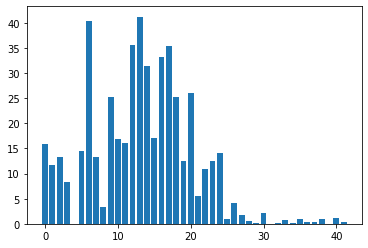

In [41]:
# Checking each feature's importance for bp
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
bp_features = dict()
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
    bp_features[i] = round(fs.scores_[i], 2)
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [42]:
# merge f_reg value with feature name using feature idx
col_names = list(X.columns)
for key in bp_features.keys():
  bp_features[key] = [col_names[key], bp_features[key]]

In [43]:
# sort and conver to dict
sorted_bp_features = sorted(bp_features.items(), key=lambda x: x[1][1], reverse=True)
sorted_bp_df=pd.DataFrame.from_dict(sorted_bp_features)
sorted_bp_df.columns = ['feature index', 'feature']
sorted_bp_df[['name','importance']] = pd.DataFrame(sorted_bp_df.feature.tolist(), index= sorted_bp_df.index)
sorted_bp_df = sorted_bp_df.drop('feature', axis = 1)

In [44]:
sorted_bp_df

,feature index,name,importance
0,13,mPACCtrailsB_bl,41.25
1,6,RAVLT_immediate_bl,40.31
2,12,mPACCdigit_bl,35.64
3,17,ADAS13_bl,35.48
4,16,ADAS11_bl,33.13
5,14,FAQ_bl,31.51
6,20,Hippocampus_bl,26.01
7,18,ADASQ4_bl,25.36
8,9,RAVLT_perc_forgetting_bl,25.22
9,15,CDRSB_bl,17.12


In [45]:
sorted_bp_df.to_csv('sorted_f_reg.csv', index = False)